In [138]:
import sys
sys.path.insert(0, "./src")

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
import sagemaker
from sagemaker import get_execution_role
import project_utils
from imageio import imread
from PIL import Image
import glob
from sagemaker.tensorflow import TensorFlow, TensorFlowModel
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

%load_ext autoreload

%autoreload 2
%aimport project_utils
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sagemaker preparation

In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()


# general prefix
prefix='kaggle-plant-prediction'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train_data')
validation_prefix    = '{}/{}'.format(prefix, 'val')

In [3]:
train_prefix

'kaggle-plant-prediction/train_data'

In [4]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

In [5]:
display(df_train.head())

display(df_test.head())

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


# Change file structure and upload data to S3

In [35]:
project_utils.change_file_structure(df_train)

In [40]:
bucket_path  = sagemaker_session.upload_data('./train_data', bucket=bucket, key_prefix=prefix)

In [13]:
train_input_path = "s3://{}/{}/train/".format(bucket, prefix)
validation_input_path = "s3://{}/{}/val/".format(bucket, prefix)


# Sagemaker training jobs

In [170]:

s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

tf_estimator = TensorFlow(entry_point='./src/model_new.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='1.12', 
                          py_version='py3'
                         )


In [171]:
tf_estimator.fit({'train': train_input_path, 'val': validation_input_path})

2020-04-05 12:35:43 Starting - Starting the training job......
2020-04-05 12:36:15 Starting - Launching requested ML instances...
2020-04-05 12:37:11 Starting - Preparing the instances for training.........
2020-04-05 12:38:27 Downloading - Downloading input data...
2020-04-05 12:39:09 Training - Downloading the training image...
2020-04-05 12:39:29 Training - Training image download completed. Training in progress.2020-04-05 12:39:32,929 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-04-05 12:39:33,292 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "val": "/opt/ml/input/data/val",
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "s3://sagemaker-eu-centra

KeyboardInterrupt: 

# Sagemaker evaluation

In [64]:
from sagemaker.tensorflow import TensorFlowPredictor

# Please note: endpoint is deployed through the GUI, you need to choose your own endpoint's name
predictor = TensorFlowPredictor('kaggle-plantnet-detection')

In [76]:
val_imgs = glob.glob("./train_data/val/*/*.jpg")

In [78]:
val_memmap = np.memmap("val.dat", dtype='float32', mode='w+', shape=(len(val_imgs),224,224,3))

for i in range(len(val_imgs)):
    img = imread(val_imgs[i])
    img = np.asarray(Image.fromarray(img).resize((224,224))).reshape(224,224,3) /255.
    val_memmap[i] = img

In [81]:
y_tmp = [img_path.split("/")[-2] for img_path in val_imgs]

y = label_binarize(y_tmp, classes=["healthy", "multiple_diseases", "rust", "scab"])


val_memmap = np.memmap("val.dat", dtype='float32', mode='r', shape=(len(val_imgs),224,224,3))

pred_list = []
for idx in range(0, len(val_memmap), 1):
    prediction = predictor.predict(val_memmap[idx:idx+1])
    pred_list.append(prediction)


In [90]:
y_score = np.asarray([pred["predictions"][0] for pred in pred_list])

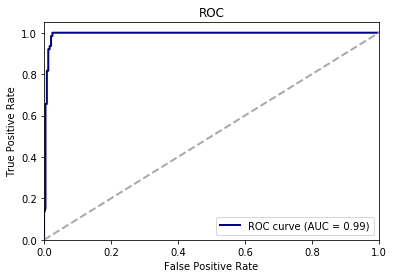

In [102]:
# based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], color='darkblue',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [104]:
deviation = y_score.argmax(axis=1) - y.argmax(axis=1)

In [125]:
target_classes = ["healthy", "multiple_diseases", "rust", "scab"]

In [127]:
img_paths = [val_imgs[i] for i in np.argwhere(deviation != 0).flatten()]
img_y_true = [y[i].argmax() for i in np.argwhere(deviation != 0).flatten()]
img_y_true = [target_classes[i] for i in img_y_true]
img_y_pred = [y_score[i].argmax() for i in np.argwhere(deviation != 0).flatten()]
img_y_pred = [target_classes[i] for i in img_y_pred]



Actual: multiple_diseases
Predicted: rust


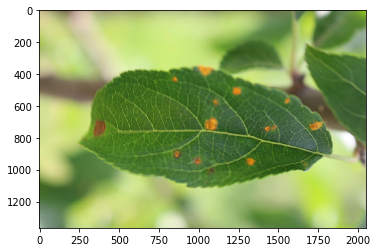

In [133]:
idx = 4

plt.imshow(imread(img_paths[idx]))
print("Actual: {}".format(img_y_true[idx]))
print("Predicted: {}".format(img_y_pred[idx]))

Actual: multiple_diseases
Predicted: rust


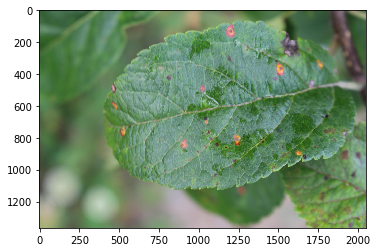

In [145]:
idx = 7

plt.imshow(imread(img_paths[idx]))
print("Actual: {}".format(img_y_true[idx]))
print("Predicted: {}".format(img_y_pred[idx]))

In [147]:
confusion_matrix(y.argmax(axis=1), y_score.argmax(axis=1))

array([[101,   1,   0,   1],
       [  1,   7,   7,   3],
       [  0,   0, 125,   0],
       [  4,   0,   0, 115]])

# Kaggle predictions

In [53]:

test_imgs = glob.glob("./images/Test*.jpg")

pred_memmap = np.memmap("pred.dat", dtype='float32', mode='w+', shape=(len(test_imgs),224,224,3))

for i in range(len(test_imgs)):
    img = imread(test_imgs[i])
    img = np.asarray(Image.fromarray(img).resize((224,224))).reshape(224,224,3) /255.
    pred_memmap[i] = img

In [70]:
pred_memmap = np.memmap("pred.dat", dtype='float32', mode='r', shape=(len(test_imgs),224,224,3))


pred_list = []
for idx in range(0, len(pred_memmap), 1):
    prediction = predictor.predict(pred_memmap[idx:idx+1])
    pred_list.append(prediction)

{'predictions': [[1.11977e-06, 0.985308, 0.0146822, 8.09372e-06]]}

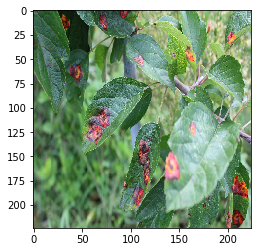

In [153]:
idx = 0
plt.imshow(np.asarray(pred_memmap[idx]))
display(pred_list[idx])

In [149]:
name = pd.DataFrame(np.asarray([name.split("/")[-1].split(".")[0] for name in test_imgs]), columns=["image_id"])
pred = pd.DataFrame(np.asarray([pred["predictions"][0] for pred in pred_list]), columns=["healthy", "multiple_diseases", "rust", "scab"])

In [150]:
name.join(pred).to_csv("submission.csv", index=None)